In [ ]:
import zipfile
import os

zip_path = '/content/FishImgDataset.zip'
extract_path = '/content/FishImgDataset/'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"File berhasil diekstrak ke: {extract_path}")

File berhasil diekstrak ke: /content/FishImgDataset/


## Pengumpulan & pembersihan data

In [ ]:
import os

image_paths = []
labels = []
dataset_dir = '/content/FishImgDataset/'

# Walk through the directory and collect image paths and labels
for root, _, files in os.walk(dataset_dir):
    # Get the class label from the subdirectory name
    label = os.path.basename(root)

    for file in files:
        # Check for valid image file extensions
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(root, file)
            image_paths.append(image_path)
            labels.append(label)

# Print the total number of images and unique classes
print(f"Total number of images found: {len(image_paths)}")
print(f"Number of unique classes: {len(set(labels))}")

Total number of images found: 13312
Number of unique classes: 31


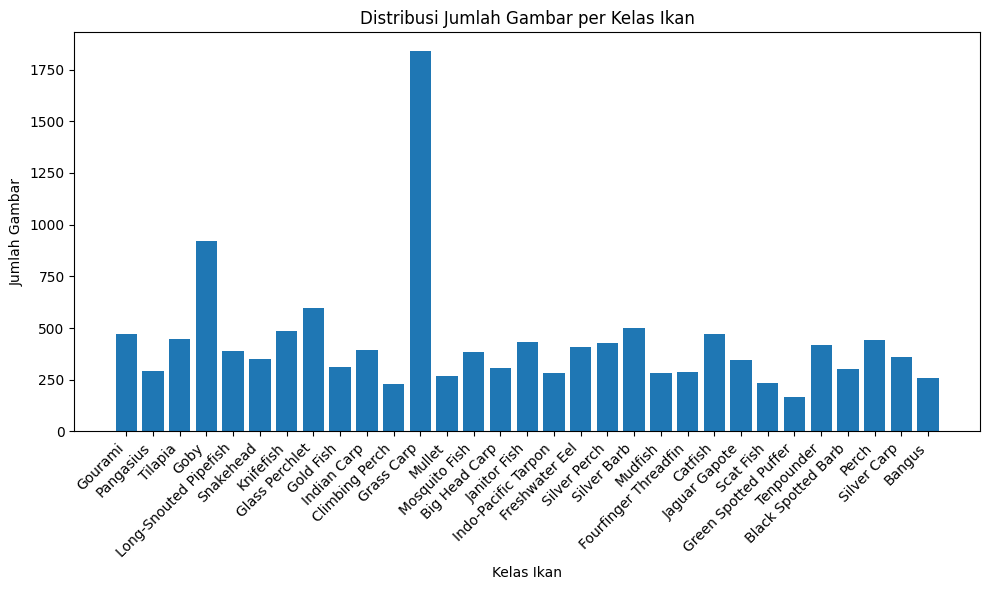

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

# Count the occurrences of each label
label_counts = Counter(labels)

# Get labels and counts for plotting
class_names = list(label_counts.keys())
counts = list(label_counts.values())

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts)
plt.xlabel('Kelas Ikan')
plt.ylabel('Jumlah Gambar')
plt.title('Distribusi Jumlah Gambar per Kelas Ikan')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Preprocessing data dan augmentasi data


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define parameters
IMAGE_SIZE = (128, 128)
BATCH_SIZE = 32
# VALIDATION_SPLIT is no longer needed here as we will load train and validation data separately
# VALIDATION_SPLIT = 0.2

# Define the paths to the training and validation directories
train_dir = '/content/FishImgDataset/FishImgDataset/train/'
validation_dir = '/content/FishImgDataset/FishImgDataset/val/'

# Create ImageDataGenerator for training with augmentation and rescaling
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    # validation_split is not used when loading from separate directories
)

# Create ImageDataGenerator for validation with only rescaling
validation_datagen = ImageDataGenerator(rescale=1./255) # No augmentation for validation

# Load images from directories using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir, # Point to the training directory
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    # subset is not used when loading from separate directories
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir, # Point to the validation directory
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # Use 'categorical' for multi-class classification
    # subset is not used when loading from separate directories
)

# Get the number of classes from the generator
num_classes = train_generator.num_classes
print(f"Number of classes found by train generator: {train_generator.num_classes}")
print(f"Number of classes found by validation generator: {validation_generator.num_classes}")
print(f"Class names: {list(train_generator.class_indices.keys())}")

Found 8801 images belonging to 31 classes.
Found 2751 images belonging to 31 classes.
Number of classes found by train generator: 31
Number of classes found by validation generator: 31
Class names: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


## Membangun dan melatih model CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [ ]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    # Set the number of units in the dense layer to num_classes and use 'softmax' activation
    Dense(num_classes, activation='softmax')
])

# Compile the model
# Use 'categorical_crossentropy' for multi-class classification
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
# Use steps_per_epoch and validation_steps based on the number of samples
# in the generators and the batch size.
# Calculate steps to cover the entire dataset
steps_per_epoch = train_generator.samples // BATCH_SIZE + (train_generator.samples % BATCH_SIZE > 0)
validation_steps = validation_generator.samples // BATCH_SIZE + (validation_generator.samples % BATCH_SIZE > 0)

# Ensure validation_steps is at least 1
if validation_steps == 0:
    validation_steps = 1


history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,  # Reduced number of epochs
    validation_data=validation_generator,
    validation_steps=validation_steps
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 231s 831ms/step - accuracy: 0.1714 - loss: 3.1311 - val_accuracy: 0.3352 - val_loss: 2.4168
Epoch 2/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 229s 829ms/step - accuracy: 0.3469 - loss: 2.3575 - val_accuracy: 0.4209 - val_loss: 2.0068
Epoch 3/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 258s 814ms/step - accuracy: 0.4110 - loss: 2.0786 - val_accuracy: 0.5147 - val_loss: 1.6511
Epoch 4/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 215s 780ms/step - accuracy: 0.4898 - loss: 1.7741 - val_accuracy: 0.5431 - val_loss: 1.5809
Epoch 5/5
276/276 ━━━━━━━━━━━━━━━━━━━━ 260s 774ms/step - accuracy: 0.5399 - loss: 1.5795 - val_accuracy: 0.5911 - val_loss: 1.3972


In [ ]:
# Train the MODEL
# Use steps_per_epoch and validation_steps based on the number of samples
# in the generators and the batch size.
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Ensure validation_steps is at least 1
if validation_steps == 0:
    validation_steps = 1


history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=5,  # Reduced number of epochs
    validation_data=validation_generator,
    validation_steps=validation_steps
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/tmp/ipython-input-43-3978110043.py", line 12, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 113, in one_step_on_data

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 60, in train_step

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 383, in _compute_loss

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/trainer.py", line 351, in compute_loss

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 691, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/trainers/compile_utils.py", line 700, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/loss.py", line 67, in __call__

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py", line 33, in call

  File "/usr/local/lib/python3.11/dist-packages/keras/src/losses/losses.py", line 2097, in categorical_crossentropy

  File "/usr/local/lib/python3.11/dist-packages/keras/src/ops/nn.py", line 1878, in categorical_crossentropy

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py", line 670, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,3] labels_size=[32,31]
	 [[{{node compile_loss/categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_multi_step_on_iterator_121359]

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,915,083 (37.82 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,610,056 (25.22 MB)

## Evaluasi Model


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Get the true labels and images from the validation generator (LATEST EVAL)
# Reset the generator to ensure consistent order
validation_generator.reset()
true_labels = validation_generator.classes
class_names = list(validation_generator.class_indices.keys())

# Collect validation data and labels in batches
x_val, y_val = [], []
for _ in range(validation_steps):
    img_batch, label_batch = next(validation_generator)
    x_val.append(img_batch)
    y_val.append(label_batch)

x_val = np.concatenate(x_val)
y_val = np.concatenate(y_val)

# Get the predictions from the model
# Predict on the collected validation data
predictions = model.predict(x_val)
predicted_classes = np.argmax(predictions, axis=1)

# Since we collected all data corresponding to validation_steps,
# the number of true labels should match the number of predictions.
# We need to get the true labels corresponding to the collected data.
# The true labels from validation_generator.classes are in the correct order
# if shuffle=False and generator is reset. We need to ensure y_val has the same order.
# The y_val collected from next(validation_generator) will correspond to the order
# if shuffle is False for the generator used in training, which it was for validation_datagen.
# So, we can use y_val to derive the true_labels.
# We need the original class indices, not one-hot encoded labels from y_val.
true_labels = np.argmax(y_val, axis=1)

86/86 ━━━━━━━━━━━━━━━━━━━━ 21s 242ms/step


In [ ]:
# Calculate classification report --LATEST--
# Ensure true_labels and predicted_classes have the same length before calculating the report
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("Classification Report:")
print(report)

Classification Report:
                       precision    recall  f1-score   support

               Bangus       0.24      0.21      0.23        52
        Big Head Carp       0.47      0.24      0.32        63
   Black Spotted Barb       0.52      0.54      0.53        63
              Catfish       0.48      0.63      0.54        97
       Climbing Perch       0.54      0.15      0.23        48
 Fourfinger Threadfin       0.48      0.43      0.46        60
       Freshwater Eel       0.44      0.50      0.47        84
       Glass Perchlet       0.53      0.73      0.61       124
                 Goby       0.69      0.46      0.55       189
            Gold Fish       0.98      0.78      0.87        65
              Gourami       0.60      0.86      0.71        97
           Grass Carp       0.81      0.86      0.83       378
 Green Spotted Puffer       0.85      0.68      0.75        34
          Indian Carp       0.66      0.81      0.73        81
  Indo-Pacific Tarpon       0.2

## Visualisasi Confusion Matrix


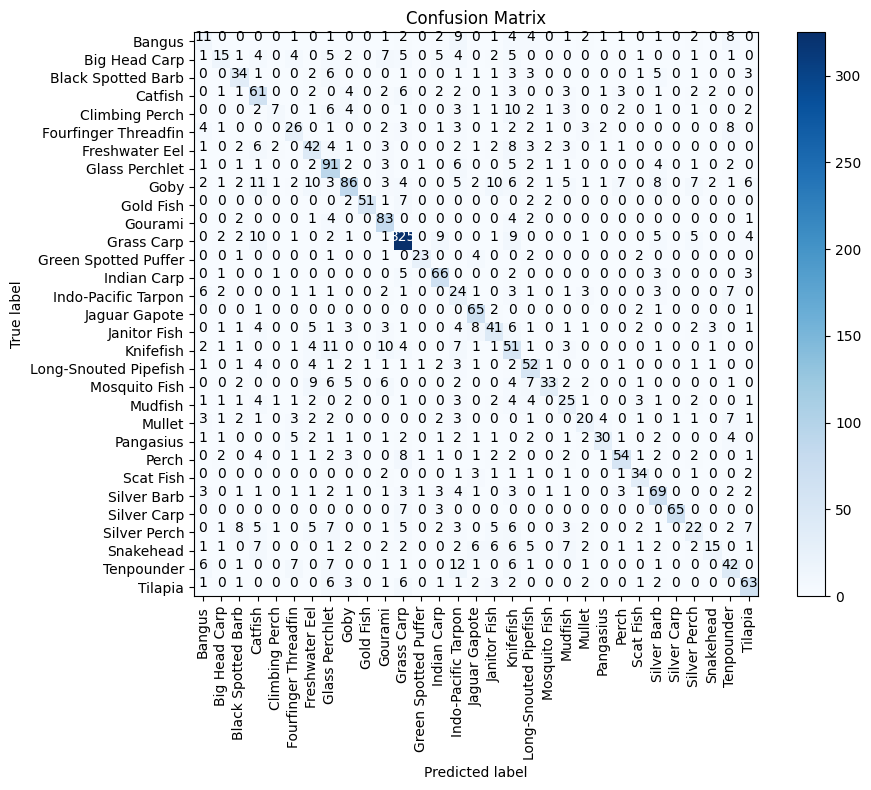

In [ ]:
# Calculate CONFUSION MATRIX
cm = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()


Macro Average AUC-ROC: 0.9542


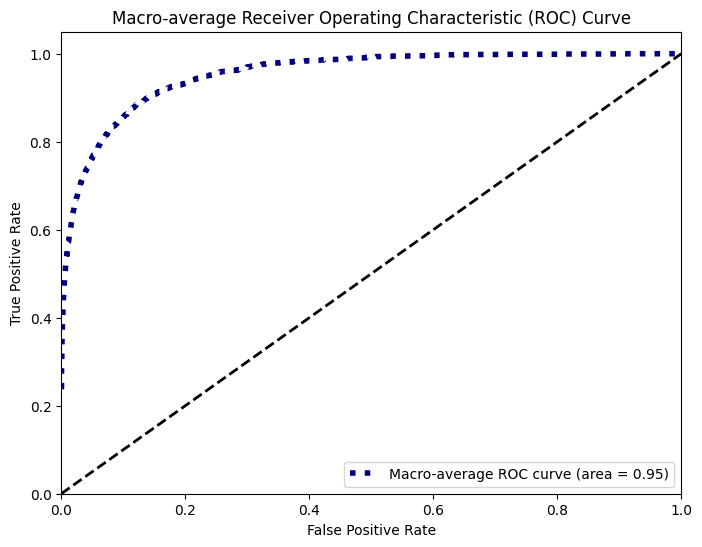

In [ ]:
# Calculate AUC-ROC (Macro Average for multi-class) (LATEST)
# Need to binarize the true labels for AUC calculation
from sklearn.preprocessing import label_binarize

# Ensure true_labels and predictions have the same length before binarizing and calculating AUC
# Use the collected y_val (one-hot encoded) and predictions
true_labels_binarized = y_val # y_val is already one-hot encoded
predictions_aligned = predictions # predictions are directly from model.predict(x_val)


# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predictions_aligned[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= num_classes

macro_fpr = all_fpr
macro_tpr = mean_tpr
macro_roc_auc = auc(macro_fpr, macro_tpr)

print(f"\nMacro Average AUC-ROC: {macro_roc_auc:.4f}")

# Plot Macro Average ROC curve
plt.figure(figsize=(8, 6))
plt.plot(macro_fpr, macro_tpr, label=f'Macro-average ROC curve (area = {macro_roc_auc:.2f})', color='navy', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Macro-average Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Matrix Mana yang Terbaik?

**Accuracy**

Akurasi model mencapai 59%, yang berarti 59% dari seluruh prediksi model sesuai dengan label kelas sebenarnya. Meskipun akurasi memberikan gambaran umum tentang performa model, metrik ini bisa menyesatkan jika data tidak seimbang, seperti pada kasus ini di mana terdapat kelas dengan jumlah data jauh lebih banyak dibandingkan kelas lain.

**Precision, Recall, dan F1-Score per Kelas**

Hasil menunjukkan bahwa:
- Kelas seperti Gold Fish, Silver Carp, dan Silver Barb memiliki F1-Score tinggi (di atas 0.85) menunjukkan bahwa model sangat mampu mengenali dan membedakan gambar-gambar dari kelas ini.
- Sebaliknya, kelas seperti Bangus, Freshwater Eel, dan Mudfish memiliki F1-Score rendah (sekitar 0.23–0.41), menunjukkan performa prediksi yang masih sangat buruk.

**Macro Average F1-Score = 0.55**

Ini mencerminkan rata-rata performa model terhadap semua kelas, tanpa memperhatikan distribusi jumlah data per kelas. Nilai ini menunjukkan bahwa jika semua kelas diperlakukan sama penting, maka performa model masih di bawah rata-rata.

**Weighted Average F1-Score = 0.58**

Ini adalah rata-rata yang mempertimbangkan jumlah data per kelas. Nilai ini sedikit lebih tinggi karena kelas-kelas dominan (misalnya Grass Carp) memiliki performa lebih baik dan memengaruhi rata-rata.

**Confusion Matrix dan AUC-ROC**

Confusion Matrix telah digunakan untuk melihat pola kesalahan prediksi antara kelas. Selain itu, model juga dievaluasi menggunakan ROC Curve dan dihitung Macro Average AUC, yang memberikan gambaran kemampuan model membedakan antar kelas secara umum (terlepas dari threshold). Nilai AUC yang tinggi pada beberapa kelas menunjukkan adanya potensi besar dari model jika dilatih lebih lanjut.



**Kesimpulan**

Matrix F1-Score (Macro Average) adalah metrik evaluasi yang paling representatif dalam kasus ini karena data per kelas tidak seimbang.

Secara umum, model klasifikasi yang dibangun telah mampu mengenali beberapa kelas ikan dengan cukup baik, khususnya kelas-kelas yang memiliki data lebih banyak. Namun, performa model secara keseluruhan masih tergolong sedang dengan nilai Macro F1-Score sebesar 0.55 dan akurasi 0.59.